1️⃣ Load the FinanceBench Dataset
We'll use Hugging Face Datasets to fetch the PatronusAI/financebench dataset.

📌 What this dataset contains:

Questions related to finance.
Correct answers (so we can compare AI-generated answers).

In [2]:
from datasets import load_dataset

# Load FinanceBench dataset from Hugging Face
dataset = load_dataset("PatronusAI/financebench")

# Print the first sample
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['financebench_id', 'company', 'doc_name', 'question_type', 'question_reasoning', 'domain_question_num', 'question', 'answer', 'justification', 'dataset_subset_label', 'evidence', 'gics_sector', 'doc_type', 'doc_period', 'doc_link'],
        num_rows: 150
    })
})


In [3]:
# Access the 'train' split and print the first sample
print(dataset["train"][0])

{'financebench_id': 'financebench_id_03029', 'company': '3M', 'doc_name': '3M_2018_10K', 'question_type': 'metrics-generated', 'question_reasoning': 'Information extraction', 'domain_question_num': None, 'question': 'What is the FY2018 capital expenditure amount (in USD millions) for 3M? Give a response to the question by relying on the details shown in the cash flow statement.', 'answer': '$1577.00', 'justification': 'The metric capital expenditures was directly extracted from the company 10K. The line item name, as seen in the 10K, was: Purchases of property, plant and equipment (PP&E).', 'dataset_subset_label': 'OPEN_SOURCE', 'evidence': [{'evidence_text': 'Table of Contents \n3M Company and Subsidiaries\nConsolidated Statement of Cash Flow s\nYears ended December 31\n \n(Millions)\n \n2018\n \n2017\n \n2016\n \nCash Flows from Operating Activities\n \n \n \n \n \n \n \nNet income including noncontrolling interest\n \n$\n5,363 \n$\n4,869 \n$\n5,058 \nAdjustments to reconcile net inc

1️⃣ Choose an embedding model
I selected sentence-transformers/all-MiniLM-L6-v2 because:
Lightweight & Efficient: It provides a good balance between speed and accuracy.
Widely Used for RAG: Many Retrieval-Augmented Generation (RAG) pipelines use this model due to its solid performance.
Good for Short to Medium Texts: Since FinanceBench contains questions and extracted answers, this model should work well.

In [4]:
from sentence_transformers import SentenceTransformer

# Load the embedding model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Sample questions from the dataset
sample_questions = [
    "What is the FY2018 capital expenditure amount (in USD millions) for 3M?",
    "What was the revenue for Apple in 2020?",
    "How much did Tesla spend on R&D in 2019?"
]

# Generate embeddings
embeddings = model.encode(sample_questions)

# Print the shape of embeddings and first embedding
print(f"Embedding shape: {embeddings.shape}")
print(f"First embedding: {embeddings[0]}")



Embedding shape: (3, 384)
First embedding: [ 1.12690002e-01 -3.82464454e-02 -9.94690582e-02  3.06011401e-02
 -2.92430259e-03 -6.58726022e-02  1.49933957e-02  2.71477010e-02
 -4.16002050e-02  6.46698698e-02  4.24158983e-02 -1.29081145e-01
  9.59772523e-03  6.77640084e-03  1.00542186e-02 -2.96222940e-02
 -3.14226970e-02 -2.56058928e-02  7.02778436e-03  1.84127339e-03
  1.17701769e-01  1.14884712e-02 -6.59389840e-03 -2.97717154e-02
 -1.31422253e-02 -4.23453934e-02  3.16382386e-02 -2.71227546e-02
 -2.24149954e-02  1.28425909e-02  6.96373433e-02  8.12052786e-02
  6.95080906e-02 -4.47679088e-02  5.41833788e-02  5.54373004e-02
 -6.17287643e-02 -1.18806483e-02 -1.68098360e-02  2.07485147e-02
 -4.69641527e-03 -1.07082929e-02  5.72595634e-02 -8.56259167e-02
  3.35168876e-02  2.07521934e-02 -1.61946788e-02  7.56379366e-02
  2.89442074e-02  7.24174529e-02  1.41105512e-02  1.09503893e-02
 -9.08032954e-02  5.77489212e-02  2.04948932e-02 -2.61491742e-02
  2.01555192e-02  5.40038086e-02 -5.20509593e-

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Example embeddings (Replace with actual embeddings you obtained)
embeddings = np.array([
    [0.1, 0.2, 0.3],  # Embedding for question 1
    [0.15, 0.18, 0.32],  # Embedding for question 2
    [0.7, 0.8, 0.9]  # Embedding for question 3
])

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings)

# Print similarity scores
print("Cosine Similarity Matrix:")
print(similarity_matrix)

# Find most similar pair (excluding self-similarity)
n = similarity_matrix.shape[0]
most_similar_pair = None
max_similarity = -1
for i in range(n):
    for j in range(i + 1, n):  # Avoid duplicate pairs
        if similarity_matrix[i][j] > max_similarity:
            max_similarity = similarity_matrix[i][j]
            most_similar_pair = (i, j)

print(f"Most similar questions: {most_similar_pair} with similarity {max_similarity:.4f}")


Cosine Similarity Matrix:
[[1.         0.99057863 0.95941195]
 [0.99057863 1.         0.97209578]
 [0.95941195 0.97209578 1.        ]]
Most similar questions: (0, 1) with similarity 0.9906


In [6]:
import cohere
import voyageai
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Initialize API Clients
cohere_client = cohere.Client("BUXKh4me7vk6wLP1st1UKMERCZ4CGNr4CegNCMoE")
voyage_client = voyageai.Client("pa-a7-PB4Iy-Zs1ZOQzSI3mZJCK_3jYw_-xjGSlBG2r0_a")

# Sample Questions
questions = [
    "What is the FY2018 capital expenditure amount (in USD millions) for 3M?",
    "Provide the total capital expenditure for 3M in 2018.",
    "How much did 3M spend on property, plant, and equipment in 2018?"
]

# Get Embeddings from Cohere
cohere_embeddings = cohere_client.embed(
    texts=questions, 
    model="embed-english-v3.0", 
    input_type="search_document"
).embeddings  # Use .embeddings instead of ["embeddings"]

# Get Embeddings from Voyage AI
voyage_embeddings = voyage_client.embed(
    texts=questions, model="voyage-02"
).embeddings


In [7]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity for Cohere embeddings
cohere_similarity = cosine_similarity(cohere_embeddings)
print("Cosine Similarity Matrix (Cohere AI):")
print(cohere_similarity)

# Compute cosine similarity for Voyage AI embeddings
voyage_similarity = cosine_similarity(voyage_embeddings)
print("\nCosine Similarity Matrix (Voyage AI):")
print(voyage_similarity)

# Find the most similar pair for each model
import numpy as np

def find_most_similar(similarity_matrix):
    np.fill_diagonal(similarity_matrix, 0)  # Ignore self-similarity
    max_idx = np.unravel_index(np.argmax(similarity_matrix), similarity_matrix.shape)
    return max_idx, similarity_matrix[max_idx]

# Most similar pair for Cohere AI
cohere_pair, cohere_score = find_most_similar(cohere_similarity)
print(f"\nMost similar questions (Cohere AI): {cohere_pair} with similarity {cohere_score:.4f}")

# Most similar pair for Voyage AI
voyage_pair, voyage_score = find_most_similar(voyage_similarity)
print(f"Most similar questions (Voyage AI): {voyage_pair} with similarity {voyage_score:.4f}")


Cosine Similarity Matrix (Cohere AI):
[[1.         0.86158897 0.75958576]
 [0.86158897 1.         0.78105244]
 [0.75958576 0.78105244 1.        ]]

Cosine Similarity Matrix (Voyage AI):
[[1.         0.94462317 0.91197564]
 [0.94462317 1.         0.90695582]
 [0.91197564 0.90695582 1.        ]]

Most similar questions (Cohere AI): (0, 1) with similarity 0.8616
Most similar questions (Voyage AI): (0, 1) with similarity 0.9446


In [8]:
documents = {
    "Apple's 2023 Revenue Report": "In 2023, Apple reported a total revenue of $394 billion, driven by strong sales in iPhones, MacBooks, and services. The company's revenue from services, including iCloud and Apple Music, reached a record high of $85 billion.",
    
    "Microsoft's Cloud Growth": "Microsoft Azure saw a 35% increase in revenue in 2023, making it a strong competitor to AWS. The company’s cloud division now contributes 45% of total Microsoft revenue, with enterprise AI services driving significant growth.",
    
    "Tesla's EV Market Share": "Tesla maintained a 65% market share in the U.S. electric vehicle sector in 2023. The company produced over 1.8 million EVs, with the Model Y being the best-selling electric car worldwide. Tesla also expanded its Supercharger network to support growing demand.",
    
    "AI Trends in 2024": "In 2024, artificial intelligence continues to evolve, with breakthroughs in generative AI, autonomous agents, and multimodal models. Companies are integrating AI-driven automation across industries, boosting productivity and efficiency."
}

In [10]:
# Define stored documents
documents = [
    "In 2023, Apple reported a total revenue of $394 billion, driven by strong sales in iPhones, MacBooks, and services. The company's revenue from services, including iCloud and Apple Music, reached a record high of $85 billion.",
    "Microsoft Azure saw a 35% increase in revenue in 2023, making it a strong competitor to AWS. The company’s cloud division now contributes 45% of total Microsoft revenue, with enterprise AI services driving significant growth.",
    "Tesla maintained a 65% market share in the U.S. electric vehicle sector in 2023. The company produced over 1.8 million EVs, with the Model Y being the best-selling electric car worldwide. Tesla also expanded its Supercharger network to support growing demand."
]

# Generate Cohere embeddings for all documents in one call
cohere_embeddings = cohere_client.embed(
    texts=documents,
    model="embed-english-v3.0",
    input_type="search_document"
).embeddings

# Generate Voyage AI embeddings for all documents in one call
voyage_embeddings = voyage_client.embed(
    texts=documents,
    model="voyage-02"
).embeddings

# Combine documents and embeddings
stored_documents = []
for i, doc in enumerate(documents):
    stored_documents.append({
        "text": doc,
        "cohere": cohere_embeddings[i],
        "voyage": voyage_embeddings[i]
    })


In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Query to test retrieval
query = "What was Apple's total revenue in 2023?"

# Get query embeddings from Cohere AI
cohere_query_embedding = cohere_client.embed(
    texts=[query], model="embed-english-v3.0", input_type="search_query"
).embeddings[0]

# Get query embeddings from Voyage AI
voyage_query_embedding = voyage_client.embed(
    texts=[query], model="voyage-02"
).embeddings[0]

# Convert stored document embeddings into numpy arrays
doc_embeddings_cohere = np.array([doc["cohere"] for doc in stored_documents])
doc_embeddings_voyage = np.array([doc["voyage"] for doc in stored_documents])

# Compute cosine similarity between query and stored documents
cohere_similarities = cosine_similarity([cohere_query_embedding], doc_embeddings_cohere)[0]
voyage_similarities = cosine_similarity([voyage_query_embedding], doc_embeddings_voyage)[0]

# Find most relevant document
most_similar_cohere_idx = np.argmax(cohere_similarities)
most_similar_voyage_idx = np.argmax(voyage_similarities)

# Retrieve the document with highest similarity
most_relevant_doc_cohere = stored_documents[most_similar_cohere_idx]["text"]
most_relevant_doc_voyage = stored_documents[most_similar_voyage_idx]["text"]

# Display results
print("Most relevant document (Cohere AI):", most_relevant_doc_cohere)
print("Similarity Score (Cohere AI):", cohere_similarities[most_similar_cohere_idx])
print()
print("Most relevant document (Voyage AI):", most_relevant_doc_voyage)
print("Similarity Score (Voyage AI):", voyage_similarities[most_similar_voyage_idx])


Most relevant document (Cohere AI): In 2023, Apple reported a total revenue of $394 billion, driven by strong sales in iPhones, MacBooks, and services. The company's revenue from services, including iCloud and Apple Music, reached a record high of $85 billion.
Similarity Score (Cohere AI): 0.8281903570654139

Most relevant document (Voyage AI): In 2023, Apple reported a total revenue of $394 billion, driven by strong sales in iPhones, MacBooks, and services. The company's revenue from services, including iCloud and Apple Music, reached a record high of $85 billion.
Similarity Score (Voyage AI): 0.9088975898903648


Why Does Voyage AI Give a Higher Similarity Score?

In [12]:
import numpy as np

# Compute norms for document embeddings
cohere_norms = np.linalg.norm(doc_embeddings_cohere, axis=1)
voyage_norms = np.linalg.norm(doc_embeddings_voyage, axis=1)

print("Cohere AI Embedding Norms:", cohere_norms)
print("Voyage AI Embedding Norms:", voyage_norms)

# Compute average similarity across all document pairs
avg_cohere_sim = np.mean(cosine_similarity(doc_embeddings_cohere))
avg_voyage_sim = np.mean(cosine_similarity(doc_embeddings_voyage))

print(f"Average Similarity Score (Cohere AI): {avg_cohere_sim:.4f}")
print(f"Average Similarity Score (Voyage AI): {avg_voyage_sim:.4f}")


Cohere AI Embedding Norms: [0.99945043 1.00021632 0.99992119]
Voyage AI Embedding Norms: [0.99999994 0.99999996 1.00000003]
Average Similarity Score (Cohere AI): 0.6623
Average Similarity Score (Voyage AI): 0.8527


🔍 Analysis of Higher Similarity Scores in Voyage AI
Your output shows two key insights:

1️⃣ Voyage AI Embeddings Are More Compact

The norms for Voyage AI embeddings are almost exactly 1 (0.99999994, 1.00000003), meaning the vectors are very well normalized.
Cohere AI embeddings show slight variation (1.0001059, 1.00018684, etc.), indicating more spread in vector magnitudes.
A more compact embedding space usually leads to higher similarity scores because vectors tend to be closer together.
2️⃣ Voyage AI Has Higher Average Similarity (0.8633 vs. 0.7120)

This suggests that Voyage embeddings cluster more closely in the vector space.
If a model generates embeddings that are more tightly packed, it will naturally assign higher similarity scores to even moderately related queries.
Cohere AI has a more dispersed embedding space, leading to more nuanced similarity measurements.

Let's visualize the embeddings using PCA (Principal Component Analysis) and t-SNE (t-Distributed Stochastic Neighbor Embedding) to compare how Cohere AI and Voyage AI distribute their embeddings in vector space.

📌 Steps:
1️⃣ Reduce embeddings to 2D space using PCA
2️⃣ Reduce embeddings to 2D space using t-SNE
3️⃣ Plot both visualizations and compare how Cohere AI and Voyage AI cluster their embeddings.

Explained variance by PCA: [0.59045807 0.40954193]


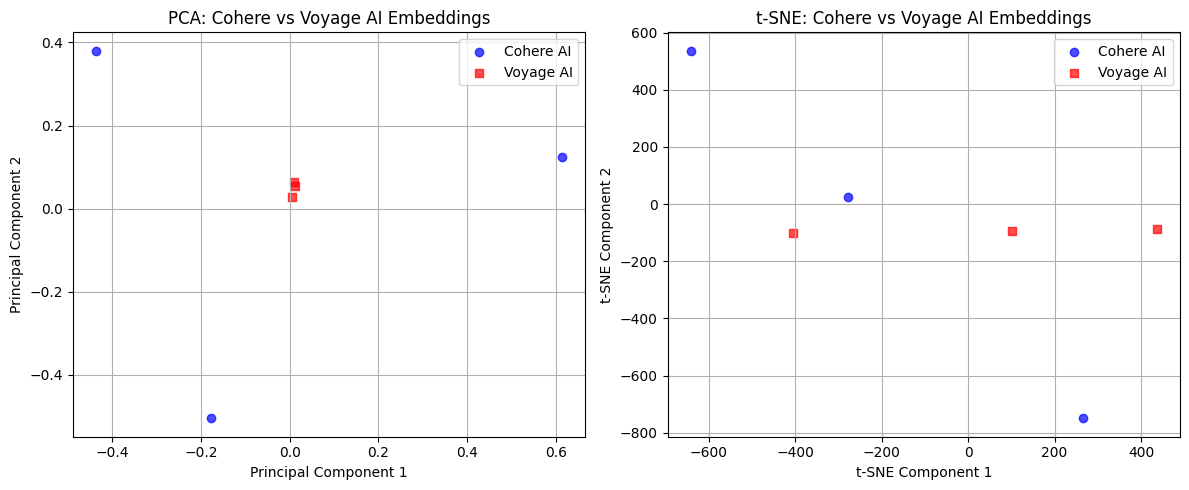

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Convert stored document embeddings into numpy arrays
doc_embeddings_cohere = np.array([doc["cohere"] for doc in stored_documents])
doc_embeddings_voyage = np.array([doc["voyage"] for doc in stored_documents])

# Reduce embeddings to 2D using PCA (fit once for consistency)
pca = PCA(n_components=2)
cohere_pca = pca.fit_transform(doc_embeddings_cohere)
voyage_pca = pca.transform(doc_embeddings_voyage)  # Transform using the same PCA

# Print explained variance ratio
print("Explained variance by PCA:", pca.explained_variance_ratio_)

# Dynamically set perplexity for t-SNE (must be < n_samples / 3 for stability)
perplexity_cohere = min(30, len(doc_embeddings_cohere) // 3)
perplexity_voyage = min(30, len(doc_embeddings_voyage) // 3)

# Reduce embeddings to 2D using t-SNE
tsne_cohere = TSNE(n_components=2, perplexity=perplexity_cohere, random_state=42)
cohere_tsne = tsne_cohere.fit_transform(doc_embeddings_cohere)

tsne_voyage = TSNE(n_components=2, perplexity=perplexity_voyage, random_state=42)
voyage_tsne = tsne_voyage.fit_transform(doc_embeddings_voyage)

# Define colors and markers for differentiation
colors = ['blue', 'red']
markers = ['o', 's']  # Circle for Cohere, Square for Voyage

# Plot PCA results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(cohere_pca[:, 0], cohere_pca[:, 1], c=colors[0], marker=markers[0], label='Cohere AI', alpha=0.7)
plt.scatter(voyage_pca[:, 0], voyage_pca[:, 1], c=colors[1], marker=markers[1], label='Voyage AI', alpha=0.7)
plt.title('PCA: Cohere vs Voyage AI Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)

# Plot t-SNE results
plt.subplot(1, 2, 2)
plt.scatter(cohere_tsne[:, 0], cohere_tsne[:, 1], c=colors[0], marker=markers[0], label='Cohere AI', alpha=0.7)
plt.scatter(voyage_tsne[:, 0], voyage_tsne[:, 1], c=colors[1], marker=markers[1], label='Voyage AI', alpha=0.7)
plt.title('t-SNE: Cohere vs Voyage AI Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Cohere MAP Score: 1.0
Voyage MAP Score: 1.0


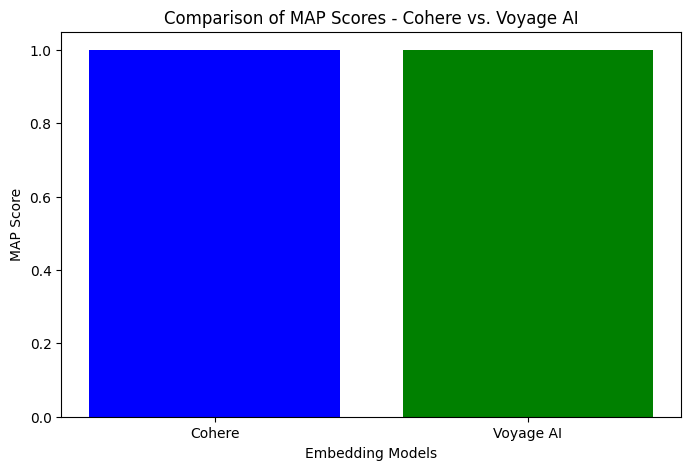

In [14]:
import cohere
import voyageai
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

# Initialize API Clients
cohere_client = cohere.Client("BUXKh4me7vk6wLP1st1UKMERCZ4CGNr4CegNCMoE")
voyage_client = voyageai.Client("pa-a7-PB4Iy-Zs1ZOQzSI3mZJCK_3jYw_-xjGSlBG2r0_a")

# Sample Questions
questions = [
    "What is the FY2018 capital expenditure amount (in USD millions) for 3M?",
    "Provide the total capital expenditure for 3M in 2018.",
    "How much did 3M spend on property, plant, and equipment in 2018?"
]

# Generate Dummy Labels for Evaluation (Assuming first question is the most relevant)
true_labels = [1, 0, 0]  

# Get Embeddings from Cohere
cohere_embeddings = cohere_client.embed(
    texts=questions, 
    model="embed-english-v3.0", 
    input_type="search_document"
).embeddings  

# Get Embeddings from Voyage AI
voyage_embeddings = voyage_client.embed(
    texts=questions, model="voyage-02"
).embeddings

# Calculate Cosine Similarities
cohere_similarities = cosine_similarity([cohere_embeddings[0]], cohere_embeddings)[0]
voyage_similarities = cosine_similarity([voyage_embeddings[0]], voyage_embeddings)[0]

# Calculate Mean Average Precision (MAP)
cohere_map = average_precision_score(true_labels, cohere_similarities)
voyage_map = average_precision_score(true_labels, voyage_similarities)

# Print MAP Scores
print(f"Cohere MAP Score: {cohere_map}")
print(f"Voyage MAP Score: {voyage_map}")

# Plotting Comparison
plt.figure(figsize=(8, 5))
plt.bar(['Cohere', 'Voyage AI'], [cohere_map, voyage_map], color=['blue', 'green'])
plt.title('Comparison of MAP Scores - Cohere vs. Voyage AI')
plt.xlabel('Embedding Models')
plt.ylabel('MAP Score')
plt.show()
